In [21]:
import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from sklearn.linear_model import Lasso, LinearRegression
import numpy as np
import exceptions
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models.annotations import Label

In [22]:
## Функции сохранения и загрузки объектов.
def save_obj(data, name):
    with open(name, 'wb') as fp:
        pickle.dump(data, fp)
        
def load_obj(name):
    with open(name, 'rb') as fp:
        return pickle.load(fp)

Загрузим данные из прошлой части проекта:
- Данные о реальных поездках в формате (дата,время $*$ регион);
- Использованные синтетические фичи;
- Предсказания композиции ARIMA + LinearRegression()
- Предсказания композиции с использованием синтетических фич.

In [31]:
npickups              = load_obj('npickups_df.p')
synth_features        = load_obj('synth_features_df.p')
arima_predictions     = load_obj('arima_predictions_df.p')
recent_predictions    = load_obj('W5_predictions.p')
diff_decorr_names     = load_obj('diff_decorr_names.p')

In [24]:
npickups.head(3)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
datetime,,,,,,,,,,,,,,,,,,,,,
2015-12-01 00:00:00,19,43,26,76,91,129,202,230,212,56,...,3,0,2,97,29,96,16,246,31,118
2015-12-01 01:00:00,16,22,12,29,71,84,89,118,177,18,...,7,0,0,2,0,17,4,104,5,75
2015-12-01 02:00:00,8,19,3,9,21,42,76,99,180,14,...,5,0,0,0,0,4,1,28,0,0


In [25]:
synth_features.head(3)

,trend_asc,trend_des,hour,harmonics_decorr_0,harmonics_decorr_1,harmonics_decorr_2,harmonics_decorr_3,harmonics_decorr_4,harmonics_decorr_5,harmonics_decorr_6,...,diff_decorr_37,diff_decorr_38,diff_decorr_39,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holidays_True
datetime,,,,,,,,,,,,,,,,,,,,,
2015-12-03 00:00:00,49,5064,0,2.598249,-4.448103,-3.822258,4.176153,2.261647,-2.982630,-5.311882,...,-247.680546,475.913425,-97.073814,0,0,1,0,0,0,0
2015-12-03 01:00:00,50,5063,1,5.197106,0.000309,3.598168,5.983577,-2.996553,-2.256994,3.555026,...,-124.811702,-299.215970,-404.483389,0,0,1,0,0,0,0
2015-12-03 02:00:00,51,5062,2,2.598354,4.447239,-5.263867,2.598362,-2.619046,5.621552,-0.000074,...,712.716681,-83.682198,217.308838,0,0,1,0,0,0,0


Стоит отметить, что в датафрейме синтетических фич содержатся гармонические признаки, и продифференцированные значения поездок ($t_0 - t_{-n}$). 

Каждый набор из этих двух разновидностей фич прогнан через PCA. Кроме того добавлены тренды (обычные линейные восходящие и нисходящие), часы, а также добавлены категориальные переменные дней недели и маркер праздника.

In [26]:
arima_predictions.head(3)

,1783_final_dt_1,1783_final_dt_2,1783_final_dt_3,1783_final_dt_4,1783_final_dt_5,1783_final_dt_6,1076_final_dt_1,1076_final_dt_2,1076_final_dt_3,1076_final_dt_4,...,1282_final_dt_3,1282_final_dt_4,1282_final_dt_5,1282_final_dt_6,1684_final_dt_1,1684_final_dt_2,1684_final_dt_3,1684_final_dt_4,1684_final_dt_5,1684_final_dt_6
2015-12-01 00:00:00,-28.315719,-51.358492,-48.410119,-58.562330,-65.317439,-23.680765,37.014835,26.328980,22.906059,30.888397,...,108.534313,122.172936,149.803229,297.544747,-3.258614,-4.847558,-5.545350,-5.444259,-4.655379,-3.359475
2015-12-01 01:00:00,-38.638788,-40.996399,-52.953780,-60.323034,-18.895300,62.512288,16.043214,15.698631,25.684783,41.974869,...,53.231456,81.816290,228.948552,508.557773,-4.062898,-5.045521,-4.977223,-4.192119,-2.896650,-1.307962
2015-12-01 02:00:00,-23.639469,-42.837238,-52.669774,-12.080084,69.042390,149.185107,17.724149,27.104101,42.999587,85.437216,...,135.558831,281.946991,562.031151,749.583314,-4.067192,-4.354028,-3.609810,-2.319049,-0.730903,0.949970


In [27]:
recent_predictions.head(3)

,prediction_1075_dt_1,prediction_1075_dt_2,prediction_1075_dt_3,prediction_1075_dt_4,prediction_1075_dt_5,prediction_1075_dt_6,prediction_1076_dt_1,prediction_1076_dt_2,prediction_1076_dt_3,prediction_1076_dt_4,...,prediction_2119_dt_3,prediction_2119_dt_4,prediction_2119_dt_5,prediction_2119_dt_6,prediction_2168_dt_1,prediction_2168_dt_2,prediction_2168_dt_3,prediction_2168_dt_4,prediction_2168_dt_5,prediction_2168_dt_6
datetime,,,,,,,,,,,,,,,,,,,,,
2015-12-03 00:00:00,20.886140,5.836445,-2.805577,-3.747410,2.144831,20.263715,30.850095,11.945652,0.393718,-1.332778,...,3.991977,-2.531743,6.730828,17.824286,40.242156,21.390962,4.233998,19.613753,69.057436,81.015801
2015-12-03 01:00:00,6.169874,2.554734,-0.757637,1.492999,19.091950,48.387714,17.384016,12.989895,8.783483,12.207051,...,-0.874760,5.143527,16.370463,19.857914,19.128018,1.009654,18.073429,64.658591,82.215268,76.542898
2015-12-03 02:00:00,4.078527,3.759145,4.807118,20.083986,52.307636,77.199418,9.715674,11.528070,17.035150,61.282627,...,4.185837,13.671456,16.800007,9.737407,-1.706916,15.007748,63.234984,77.778233,75.416294,72.255405


## 1.
Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте Qmay — качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.

In [28]:
test_end      = pd.to_datetime('2016-04-30 23')
train_end     = pd.to_datetime('2016-05-31 23')
predict_start = pd.to_datetime('2016-05-31 23')
predict_end   = pd.to_datetime('2016-06-30 17')

In [33]:
%%time
##Формируем массив из 6 датафреймов для каждого 'delta(t)'
#это нужно, чтобы сразу сдвинуть нужные данные на  'delta(t)' и не запутаться --->

data_list  = []
for dt in range (1,7):
    names_arima = []
    for region in npickups.columns:
        name_arima = '{}_final_dt_{}'.format(region, dt) #Имя колонки с предсказанием аримы
        names_arima.append(name_arima)
    data_list.append(pd.concat([arima_predictions.loc[:, names_arima],
                                synth_features.loc[:, diff_decorr_names], 
                                synth_features.drop(diff_decorr_names, axis = 'columns').shift(-dt),
                                npickups.shift(-dt)],axis = 'columns'))

    
##--->  один массив делим на 3 разных (аримы, фичи, отклики). --->
data_list           = map(lambda x: x.dropna(), data_list)
gen_features_list   = map(lambda x: x.loc[:, synth_features.columns],          data_list)
arima_features_list = map(lambda x: x.loc[:, arima_predictions.columns],       data_list)
response_list       = map(lambda x: x.loc[:, npickups.columns],                data_list)


##--->  Создаем словарь "словарь[регион]['delta(t)'][тип данных (x/y/train/test)]' --->
data_dict = {}
for region in npickups.columns:
    dt_ = {}
    for dt in range(1,7):
        data_ = {}
        index = dt - 1
        
        name_arima = '{}_final_dt_{}'.format(region, dt)
        
        data_['X_test']    = pd.concat([arima_features_list[index].loc[:test_end,  name_arima],
                                          gen_features_list[index].loc[:test_end,  :]], axis = 'columns')
        data_['X_train']   = pd.concat([arima_features_list[index].loc[:train_end, name_arima],
                                          gen_features_list[index].loc[:train_end, :]], axis = 'columns')
        data_['X_may']     = pd.concat([arima_features_list[index].loc['2016-04-30 23':'2016-05-31 17', name_arima],
                                          gen_features_list[index].loc['2016-04-30 23':'2016-05-31 17', :]], axis = 'columns')
        data_['X_june']    = pd.concat([arima_features_list[index].loc['2016-05-31 23':'2016-06-30 17', name_arima],
                                          gen_features_list[index].loc['2016-05-31 23':'2016-06-30 17', :]], axis = 'columns')
        data_['y_test']  = response_list[index].loc[:test_end,   region]
        data_['y_train'] = response_list[index].loc[:train_end,  region]
        data_['y_may']  = response_list[index].loc['2016-04-30 23':'2016-05-31 17',   region]
        data_['y_june'] = response_list[index].loc['2016-05-31 23':'2016-06-30 17',   region]
        
        dt_[dt] = data_
    data_dict[region] = dt_

Wall time: 8.97 s


Обучим модели, сделаем предсказания.

In [34]:
%%time
distances = []
for region in npickups.columns:
    for dt in range(1, 7):
        X = data_dict[region][dt]['X_test']
        y = data_dict[region][dt]['y_test']
        estimator = Lasso()
        estimator.fit(X, y)
        y_prediction = estimator.predict(data_dict[region][dt]['X_may'])
        y_actual     = data_dict[region][dt]['y_may']
        distance = np.abs(y_actual - y_prediction)
        distances.append(distance)

Wall time: 34.7 s


In [35]:
print('Q-метрика для мая составляет: {}'.format(round(pd.DataFrame(distances).sum().sum() / (739. * 6. * 102.), 3)))

Q-метрика для мая составляет: 19.728


## 2.
Попробуйте добавить признаки. Используйте идеи, которые мы предложили, или какие-то свои. Обучайте обновлённые модели на данных до апреля 2016 включительно и считайте качество новых прогнозов на мае. Удаётся ли вам улучшить качество? Не нужно ли увеличить сложность регрессионной модели? Если добавляемый признак не улучшает качество, всё равно оставьте доказательства этому в ноутбуке, чтобы ваши коллеги это видели при проверке.

В качестве новых признаков будем использовать данные о погоде, полученные с наземной метеорологической станции $WBAN:94728$, расположенной в Нью-Йорке. Данные загружены с сайта Национального Управления по Исследованию Океанов и Атмосферы (NOAA, National Oceanic and Atmospheric Administration - http://www.noaa.gov).

Координаты самой станции: 40.77898, -73.96925.

In [36]:
##Перевод координат в формат WebMercator
def wgs84_to_web_mercator(longitude, latitude):
    """Converts decimal longitude/la94728titude to Web Mercator format"""
    k = 6378137
    x = longitude * (k * np.pi/180.0)
    y = np.log(np.tan((90 + latitude) * np.pi/360.0)) * k
    return x, y

In [37]:
#Погодный файл
weather = pd.read_csv('weather.csv', index_col='DATE', parse_dates=True)


#Координаты станции
station_latitude  = 40.77898  
station_longitude = -73.96925

#Координаты границ зоны видимости на карте
NY_lat_0 = 40.49612
NY_lat_1 = 40.91553
NY_lon_0 = -73.70001
NY_lon_1 = -74.25559

#Координаты в формате web mercator
station_longitude_wmer, station_latitude_wmer = wgs84_to_web_mercator(station_longitude, station_latitude)
NY_coord_0_wmer = wgs84_to_web_mercator(NY_lon_0, NY_lat_0)
NY_coord_1_wmer = wgs84_to_web_mercator(NY_lon_1, NY_lat_1)

In [38]:
fig = figure(tools='pan, wheel_zoom',  x_range=(NY_coord_1_wmer[0], NY_coord_0_wmer[0]),
                                       y_range=(NY_coord_1_wmer[1], NY_coord_0_wmer[1]))
fig.circle(station_longitude_wmer, station_latitude_wmer,  size = 10)

label = Label(x = station_longitude_wmer, y = station_latitude_wmer, x_offset=12, text="Meteo station", text_baseline="middle")
fig.add_layout(label)

fig.axis.visible = False
fig.add_tile(CARTODBPOSITRON)
output_notebook()
show(fig)



Loading BokehJS ...

Файл содержит множество данных, дату и время их фиксации. Нам понадобятся лишь температуры сухого и влажного термометра, (которые в совокупности характеризуют температуру и влажность воздуха), а также скорость ветра и величину осадков.

Данные из файла содержат пропущенные значения, которые следует заполнить:

In [42]:
weather_names = ['HOURLYDRYBULBTEMPC', 'HOURLYWETBULBTEMPC', 'HOURLYWindSpeed', 'HOURLYPrecip']
weather = weather.loc[:, weather_names]
weather = weather.apply(lambda x: pd.to_numeric(x, errors='coerce'))
weather.fillna(method='ffill', inplace = True)
weather.fillna(method='bfill', inplace = True)
weather.head()

,HOURLYDRYBULBTEMPC,HOURLYWETBULBTEMPC,HOURLYWindSpeed,HOURLYPrecip
DATE,,,,
2015-12-01 00:00:00,7.2,5.4,9.000000,0.01
2015-12-01 01:00:00,6.7,5.4,9.000000,0.01
2015-12-01 02:00:00,6.7,5.7,8.000000,0.01
2015-12-01 03:00:00,6.7,5.9,7.333333,0.03
2015-12-01 04:00:00,7.2,6.4,8.000000,0.07


Теперь нужно применить ресэмплинг к индексам, чтобы получить округленные до часов значения времени.

In [40]:
weather = weather.resample('1h').mean()
weather.head()

,HOURLYDRYBULBTEMPC,HOURLYWETBULBTEMPC,HOURLYWindSpeed,HOURLYPrecip
DATE,,,,
2015-12-01 00:00:00,7.2,5.4,9.000000,0.01
2015-12-01 01:00:00,6.7,5.4,9.000000,0.01
2015-12-01 02:00:00,6.7,5.7,8.000000,0.01
2015-12-01 03:00:00,6.7,5.9,7.333333,0.03
2015-12-01 04:00:00,7.2,6.4,8.000000,0.07


Добавим погодные данные в список признаков.

In [41]:
new_synth_features = pd.concat([weather.loc[synth_features.index,:], synth_features], axis = 'columns')

In [43]:
%%time
##Формируем массив из 6 датафреймов для каждого 'delta(t)'
#это нужно, чтобы сразу сдвинуть нужные данные на  'delta(t)' и не запутаться --->

data_list  = []
for dt in range (1,7):
    names_arima = []
    for region in npickups.columns:
        name_arima = '{}_final_dt_{}'.format(region, dt) #Имя колонки с предсказанием аримы
        names_arima.append(name_arima)
    data_list.append(pd.concat([arima_predictions.loc[:, names_arima],
                                new_synth_features.loc[:, diff_decorr_names], 
                                new_synth_features.loc[:, weather_names],
                                new_synth_features.drop(diff_decorr_names, axis = 'columns').shift(-dt),
                                npickups.shift(-dt)],axis = 'columns'))

    
##--->  один массив делим на 3 разных (аримы, фичи, отклики). --->
data_list           = map(lambda x: x.dropna(), data_list)
gen_features_list   = map(lambda x: x.loc[:, new_synth_features.columns],      data_list)
arima_features_list = map(lambda x: x.loc[:, arima_predictions.columns],       data_list)
response_list       = map(lambda x: x.loc[:, npickups.columns],                data_list)


##--->  Создаем словарь "словарь[регион]['delta(t)'][тип данных (x/y/train/test)]' --->
data_dict = {}
for region in npickups.columns:
    dt_ = {}
    for dt in range(1,7):
        data_ = {}
        index = dt - 1
        
        name_arima = '{}_final_dt_{}'.format(region, dt)
        
        data_['X_test']    = pd.concat([arima_features_list[index].loc[:test_end,  name_arima],
                                          gen_features_list[index].loc[:test_end,  :]], axis = 'columns')
        data_['X_train']   = pd.concat([arima_features_list[index].loc[:train_end, name_arima],
                                          gen_features_list[index].loc[:train_end, :]], axis = 'columns')
        data_['X_may']     = pd.concat([arima_features_list[index].loc['2016-04-30 23':'2016-05-31 17', name_arima],
                                          gen_features_list[index].loc['2016-04-30 23':'2016-05-31 17', :]], axis = 'columns')
        data_['X_june']    = pd.concat([arima_features_list[index].loc['2016-05-31 23':'2016-06-30 17', name_arima],
                                          gen_features_list[index].loc['2016-05-31 23':'2016-06-30 17', :]], axis = 'columns')
        data_['y_test']  = response_list[index].loc[:test_end,   region]
        data_['y_train'] = response_list[index].loc[:train_end,  region]
        data_['y_may']  = response_list[index].loc['2016-04-30 23':'2016-05-31 17',   region]
        data_['y_june'] = response_list[index].loc['2016-05-31 23':'2016-06-30 17',   region]
        
        dt_[dt] = data_
    data_dict[region] = dt_

Wall time: 9.07 s


## 3.
Когда вы примете решение остановиться и перестать добавлять признаки, постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза.

In [44]:
%%time
distances = []
for region in npickups.columns:
    for dt in range(1, 7):
        X = data_dict[region][dt]['X_test']
        y = data_dict[region][dt]['y_test']
        estimator = Lasso()
        estimator.fit(X, y)
        y_prediction = estimator.predict(data_dict[region][dt]['X_may'])
        y_actual     = data_dict[region][dt]['y_may']
        distance = np.abs(y_actual - y_prediction)
        distances.append(distance)

Wall time: 38.2 s


In [45]:
print('Q-метрика для мая составляет: {}'.format(round(pd.DataFrame(distances).sum().sum() / (739. * 6. * 102.), 3)))

Q-метрика для мая составляет: 19.009


Качество прогноза по тестовой выборке увеличилось. Погодные данные дали некоторый прирост в точности предсказаний.

## 4.
Переобучите итоговые модели на данных до мая 2016 включительно, постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате: geoID, histEndDay, histEndHour, step, y

In [48]:
%%time
distances = []
predictions = pd.DataFrame()
for region in npickups.columns:
    for dt in range(1, 7):
        name = 'prediction_{}_dt_{}'.format(region, dt)
        X = data_dict[region][dt]['X_train']
        y = data_dict[region][dt]['y_train']
        estimator = Lasso()
        estimator.fit(X, y)
        y_prediction = estimator.predict(data_dict[region][dt]['X_june'])
        y_actual     = data_dict[region][dt]['y_june']
        predictions[name] = y_prediction
        distance = np.abs(y_actual - y_prediction)
        distances.append(distance)
        predictions.index = y_actual.index
        
answer=[]
for region in sorted(list(npickups.columns)):
    for dt in pd.date_range('2016-05-31 23', '2016-06-30 17', freq = 'h'):
        for i in range (1, 7):
            answer.append(['{}_{}_{}_{}'.format(region, dt.date(), dt.hour,  i), 
                          predictions.loc[dt,
                                          'prediction_{}_dt_{}'.format(region, i)]])

Wall time: 53.8 s


### 6. 
Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

In [49]:
pd.DataFrame(answer).to_csv('D:/ans_C6_W6_01.csv', header = ['id', 'y'], index = False)

Ссылка на сабмишн: https://www.kaggle.com/submissions/5643294/5643294.zip

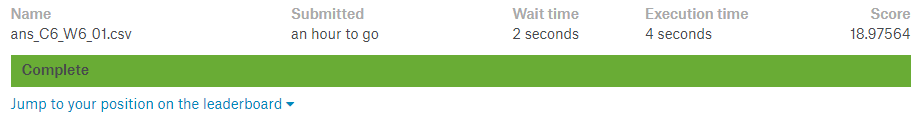

### 7.
Загрузите ноутбук в форму.